This is a tutorial originally from "https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb". I changed some of the code to encourage modular programming

### Loading the Dataset

In [1]:
%run utils.py
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

CPython 3.6.9
IPython 7.10.2

numpy 1.17.4
pandas 1.0.3
torch 1.2.0+cu92
arff2pandas 1.0.1


In [2]:
import torch
import os
import time
import sys

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p
from torch_device import torch_device


device = torch_device

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
os.getcwd()

'C:\\Users\\Ekele\\Desktop\\Anomaly_Detection_ECG'

In [5]:
DATA_PATH = "data"
os.chdir(DATA_PATH)
%run download_dataset.py

Downloading...

Extracting
Extracting successfully done to C:\Users\Ekele\Desktop\Anomaly_Detection_ECG\data\ECG5000.


In [6]:
os.getcwd()

'C:\\Users\\Ekele\\Desktop\\Anomaly_Detection_ECG'

In [7]:
DATASET_PATH = os.path.join(DATA_PATH, "ECG5000")
 
print("\n" + "ECG5000 Dataset is now located at {}".format(DATASET_PATH))
os.listdir(DATASET_PATH)


ECG5000 Dataset is now located at data\ECG5000


['ECG5000.txt',
 'ECG5000.zip',
 'ECG5000_TEST.arff',
 'ECG5000_TEST.ts',
 'ECG5000_TEST.txt',
 'ECG5000_TRAIN.arff',
 'ECG5000_TRAIN.ts',
 'ECG5000_TRAIN.txt']

### Load Data

In [8]:
train_data = None
test_data = None


def load_path(train_path, test_path):
    train = None
    test = None
    df = None
    train_path = os.path.join(DATASET_PATH, train_path)
    test_path = os.path.join(DATASET_PATH, test_path)
    
    with open(train_path) as f:
        train = a2p.load(f)
    with open(test_path) as f:
        test = a2p.load(f)
    
    df = train.append(test)
    
    return train, test, df

In [9]:
train_data, test_data, df = load_path("ECG5000_TRAIN.arff", "ECG5000_TEST.arff")

In [10]:
train_data.head(10)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
5,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134,1
6,-0.297161,-2.766635,-4.102185,-4.589669,-4.219357,-3.650443,-2.300518,-1.293917,-1.065658,-0.490520,...,0.581779,0.684406,0.911651,0.979483,1.053458,0.974787,1.110407,1.288165,-0.823386,1
7,0.446769,-1.507397,-3.187468,-4.507462,-4.604201,-3.636115,-2.311604,-1.597727,-1.362450,-0.669216,...,1.001306,1.292059,1.378667,1.014765,0.820793,1.034388,1.258433,0.961215,-0.999476,1
8,0.087631,-1.753490,-3.304473,-4.704657,-4.686415,-3.611817,-2.267268,-1.570893,-1.417790,-0.500788,...,1.709046,2.142926,2.393528,1.925550,1.027624,0.573453,0.192971,-0.648683,-2.441068,1
9,-0.832281,-1.700368,-2.257301,-2.853671,-2.853301,-2.701487,-2.285726,-1.555512,-1.266622,-1.085957,...,2.110504,2.203668,2.227544,2.171733,2.045938,2.126372,2.126852,1.679299,0.965814,1


In [11]:
test_data.head(10)

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,1
5,1.649272,1.121169,-0.628753,-1.939899,-3.439175,-4.010777,-3.238067,-2.127737,-1.798464,-1.323561,...,0.636727,1.166689,1.062871,1.628234,2.175072,2.500749,2.092176,1.455313,2.124303,1
6,-0.323103,-1.510804,-2.768216,-3.788649,-4.100396,-3.516576,-2.940032,-1.828790,-1.089045,-0.858473,...,1.052238,0.213416,-1.003917,-1.676931,-2.055868,-1.968963,-1.548612,-1.411230,-2.620855,1
7,-1.309274,-4.045362,-4.757328,-4.657040,-3.634479,-2.469447,-1.640088,-1.408992,-0.706937,-0.272103,...,1.371353,1.257078,1.246963,1.156629,0.311326,-0.325923,-0.385273,0.385835,-0.393619,1
8,-1.736906,-3.647089,-4.005470,-4.413745,-4.082557,-3.234594,-1.935797,-1.367653,-1.055027,-0.545169,...,1.130086,1.317606,1.181094,0.976701,0.541003,0.288060,0.479704,0.658353,-0.326727,1
9,-1.101873,-1.965967,-2.399643,-2.905194,-3.107600,-3.041231,-2.105358,-1.621213,-1.589307,-1.232691,...,1.436628,0.931638,0.332091,0.409455,0.489593,0.890026,1.026954,0.937848,0.321598,1


In [12]:
train_data.shape

(500, 141)

In [13]:
df.shape

(5000, 141)

In [14]:
test_data.shape

(4500, 141)

In [15]:
target_names = ['Normal','R on T','PVC','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

### Exploratory Data Analysis

In [16]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

[Text(0, 0, 'Normal'),
 Text(0, 0, 'R on T'),
 Text(0, 0, 'PVC'),
 Text(0, 0, 'SP'),
 Text(0, 0, 'UB')]

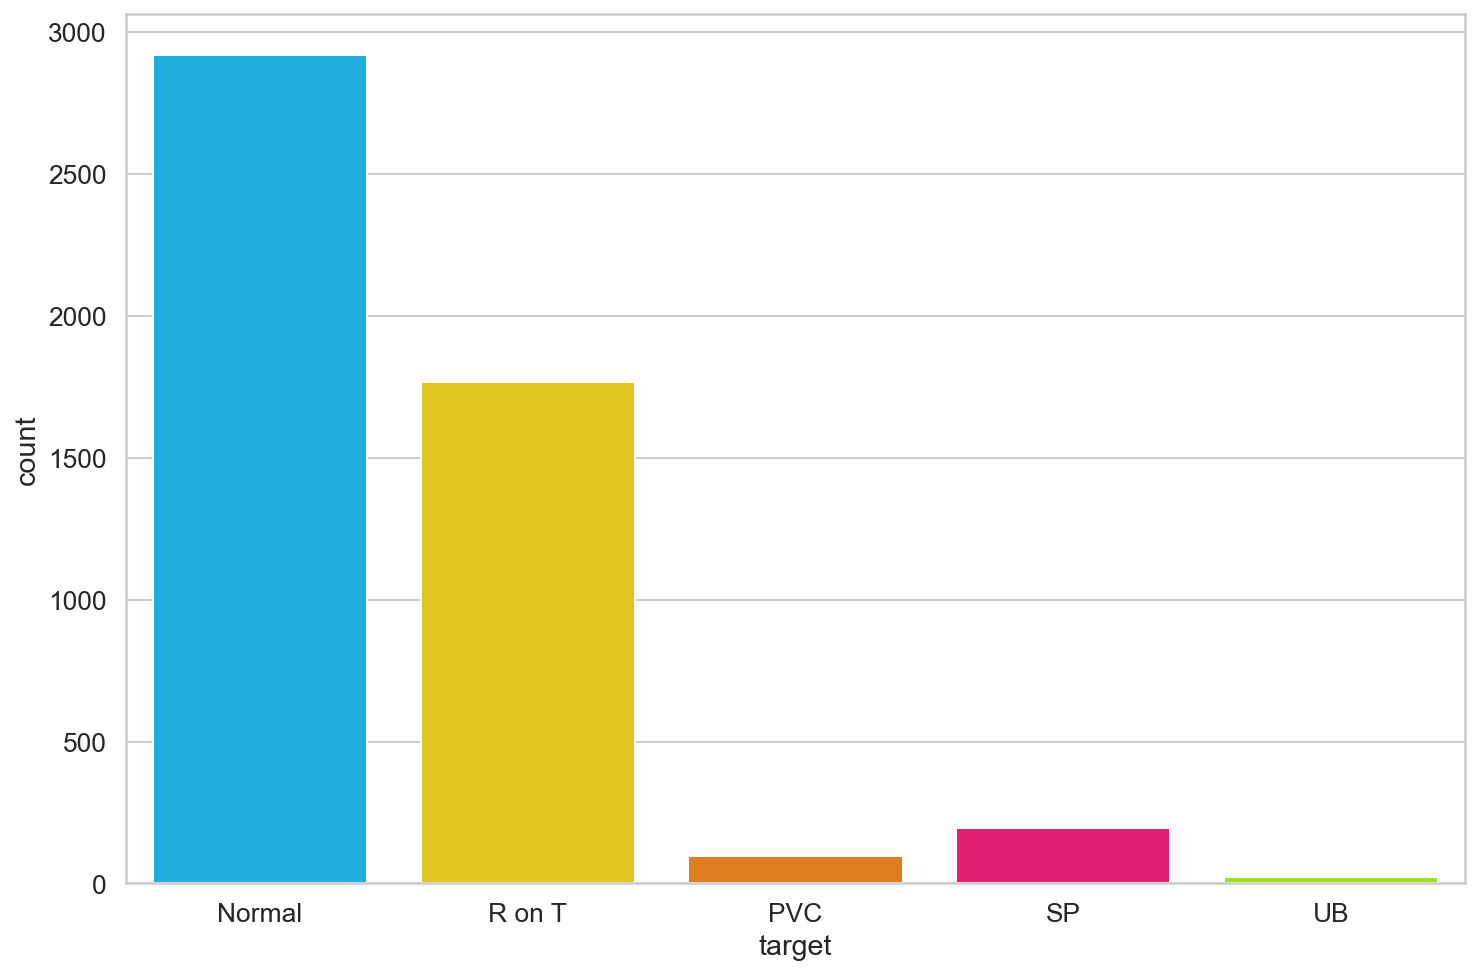

In [17]:
ax = sns.countplot(df.target)
ax.set_xticklabels(target_names)

In [18]:
def plot_time_series_classes(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)
    
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

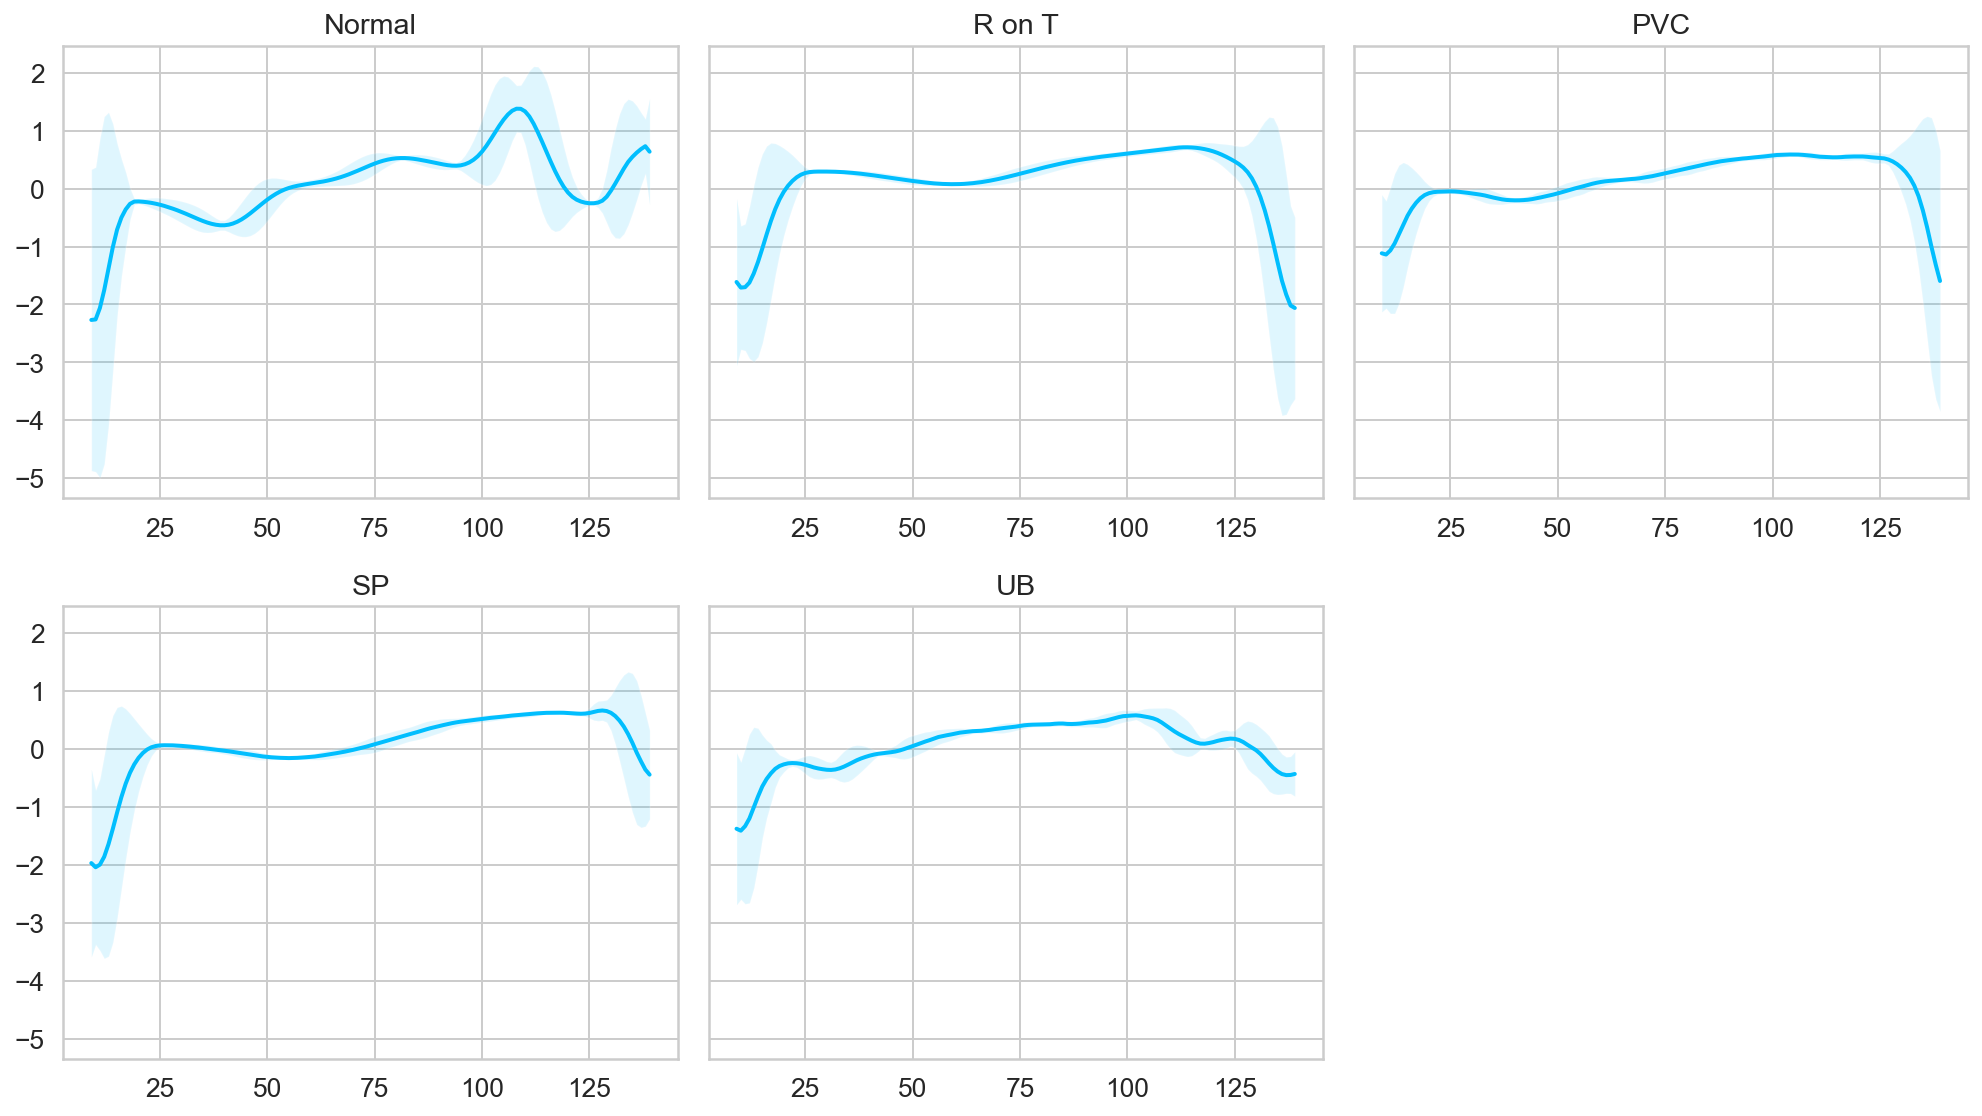

In [19]:
classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

for idx, cls in enumerate(classes):
    ax = axs.flat[idx]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0).to_numpy()
    plot_time_series_classes(data, target_names[idx], ax)
    
fig.delaxes(axs.flat[-1])
fig.tight_layout()

### LSTM Autoencoder

#### Reconstruction Loss

#### Data Preprocessing

In [20]:
TARGET_NORMAL = 1

In [21]:
def normal_anomaly_df(df=None, RANDOM_SEED=None):

    normal_df = df[df.target == str(TARGET_NORMAL)].drop(labels='target', axis=1)
    anomaly_df = df[df.target != str(TARGET_NORMAL)].drop(labels='target', axis=1)
    
    train_df, val_df = train_test_split(
        normal_df,
        test_size=0.15,
        random_state=RANDOM_SEED)
    
    val_df, test_df = train_test_split(
        val_df,
        test_size=0.33,
        random_state=RANDOM_SEED)
    
    return train_df, val_df, test_df, anomaly_df

In [22]:
def create_dataset(df, name):
    
    print('DataFrame dimension: ', df.astype(np.float32).to_numpy().shape)
    sequences = df.astype(np.float32).to_numpy().tolist()
    
    # Expanding the 2D sequences to 3D inorder to be accepted into Pytorch without errors
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    print('Expanded {} dataset size: {} '.format(name, torch.stack(dataset).shape))
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [23]:
train_df, val_df, test_df, anomaly_df = normal_anomaly_df(df=df, RANDOM_SEED=RANDOM_SEED)

In [24]:
train_dataset, seq_len, n_features = create_dataset(train_df, "Train Dataframe")
val_dataset, _, _ = create_dataset(val_df, "Validation Dataframe")
test_normal_dataset, _, _ = create_dataset(test_df, "Test Dataframe")
test_anomaly_dataset, _, _ = create_dataset(anomaly_df, "Anomaly Dataframe")

DataFrame dimension:  (2481, 140)
Expanded Train Dataframe dataset size: torch.Size([2481, 140, 1]) 
DataFrame dimension:  (293, 140)
Expanded Validation Dataframe dataset size: torch.Size([293, 140, 1]) 
DataFrame dimension:  (145, 140)
Expanded Test Dataframe dataset size: torch.Size([145, 140, 1]) 
DataFrame dimension:  (2081, 140)
Expanded Anomaly Dataframe dataset size: torch.Size([2081, 140, 1]) 


#### Encoder

In [25]:
class Encoder(nn.Module):
    
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super().__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim
        
        self.rnn1 = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.embedding_dim,
            num_layers=1,
            batch_first=True
        )
        
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [26]:
class Decoder(nn.Module):
    
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super().__init__()
        
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        
        self.rnn1 = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.input_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, self.n_features)
        
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        
        return self.output_layer(x)

In [27]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super().__init__()
        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [28]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

### Training

In [29]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = sys.maxsize
    
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
        print("Epoch {}: train loss {} val loss {}".format(epoch, train_loss, val_loss))
        
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [30]:
%%time
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)

Epoch 1: train loss 62.62564343379804 val loss 55.58668807098076
Epoch 2: train loss 52.50415950300039 val loss 50.01347050976021
Epoch 3: train loss 51.883136610118 val loss 52.55603962139872
Epoch 4: train loss 51.956839104421384 val loss 50.11141411843153
Epoch 5: train loss 51.83272484760523 val loss 47.14300843066323
Epoch 6: train loss 43.223818026353925 val loss 32.381932600366376
Epoch 7: train loss 31.86933444767698 val loss 31.50379038345285
Epoch 8: train loss 28.75453484245771 val loss 30.247374388138184
Epoch 9: train loss 27.84792165129668 val loss 26.234062178549912
Epoch 10: train loss 27.48161314341965 val loss 24.58790139533554
Epoch 11: train loss 26.615425100637896 val loss 27.2606947869571
Epoch 12: train loss 52.01295146380928 val loss 50.03021647742991
Epoch 13: train loss 49.49847165945315 val loss 40.6158185379497
Epoch 14: train loss 37.21908848711388 val loss 36.58628153882336
Epoch 15: train loss 30.789405822369517 val loss 24.115623168164145
Epoch 16: train

Epoch 123: train loss 11.530036154892693 val loss 11.31146716583304
Epoch 124: train loss 11.15022976655049 val loss 10.622742460856259
Epoch 125: train loss 10.042020455621413 val loss 9.721355705131035
Epoch 126: train loss 9.623414859902422 val loss 10.5143926184332
Epoch 127: train loss 12.002139633483148 val loss 10.857423133003834
Epoch 128: train loss 10.582510466923496 val loss 9.782317890648956
Epoch 129: train loss 9.672267132543451 val loss 9.681788481949946
Epoch 130: train loss 8.836825089798682 val loss 9.695672240273538
Epoch 131: train loss 15.271448006220567 val loss 18.4353813164877
Epoch 132: train loss 14.626744068903772 val loss 11.855614170686376
Epoch 133: train loss 12.122462640506324 val loss 11.05540563466199
Epoch 134: train loss 12.591452868029938 val loss 33.65247791537653
Epoch 135: train loss 11.214877137249873 val loss 11.296342447756093
Epoch 136: train loss 9.912432908531352 val loss 9.934714737198865
Epoch 137: train loss 14.71647101801665 val loss 10

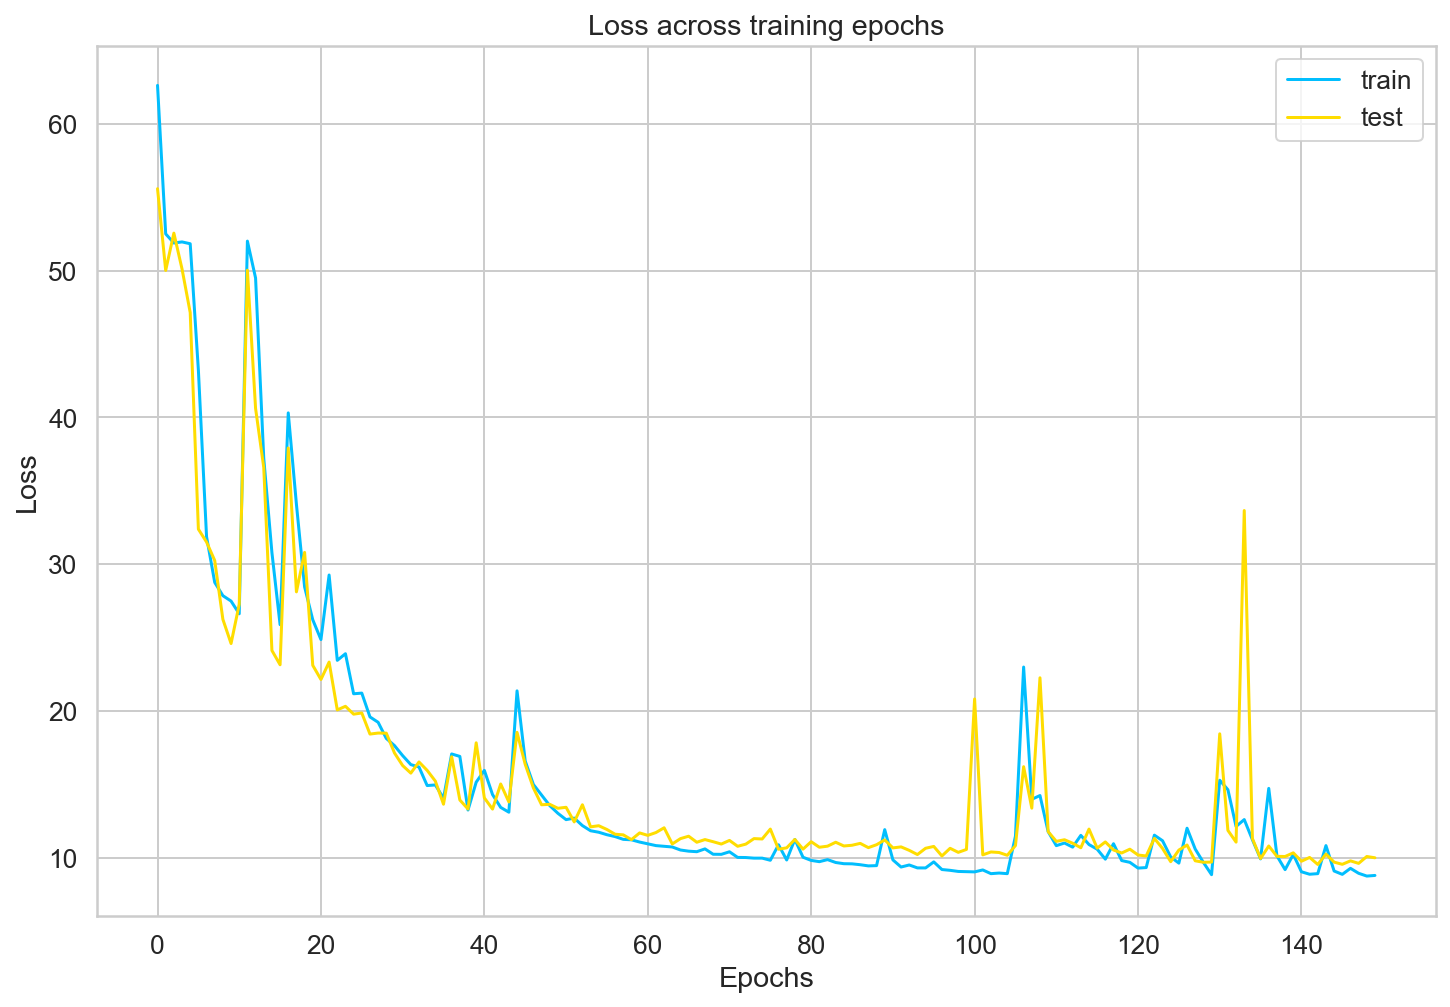

In [36]:
### gca() get current axis
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.title('Loss across training epochs')
plt.show()

### Saving the model

In [37]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

C:\Users\Ekele\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RecurrentAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Ekele\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Ekele\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Choosing a threshold

In [38]:
def predict(model, dataset):
    
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    
    return predictions, losses

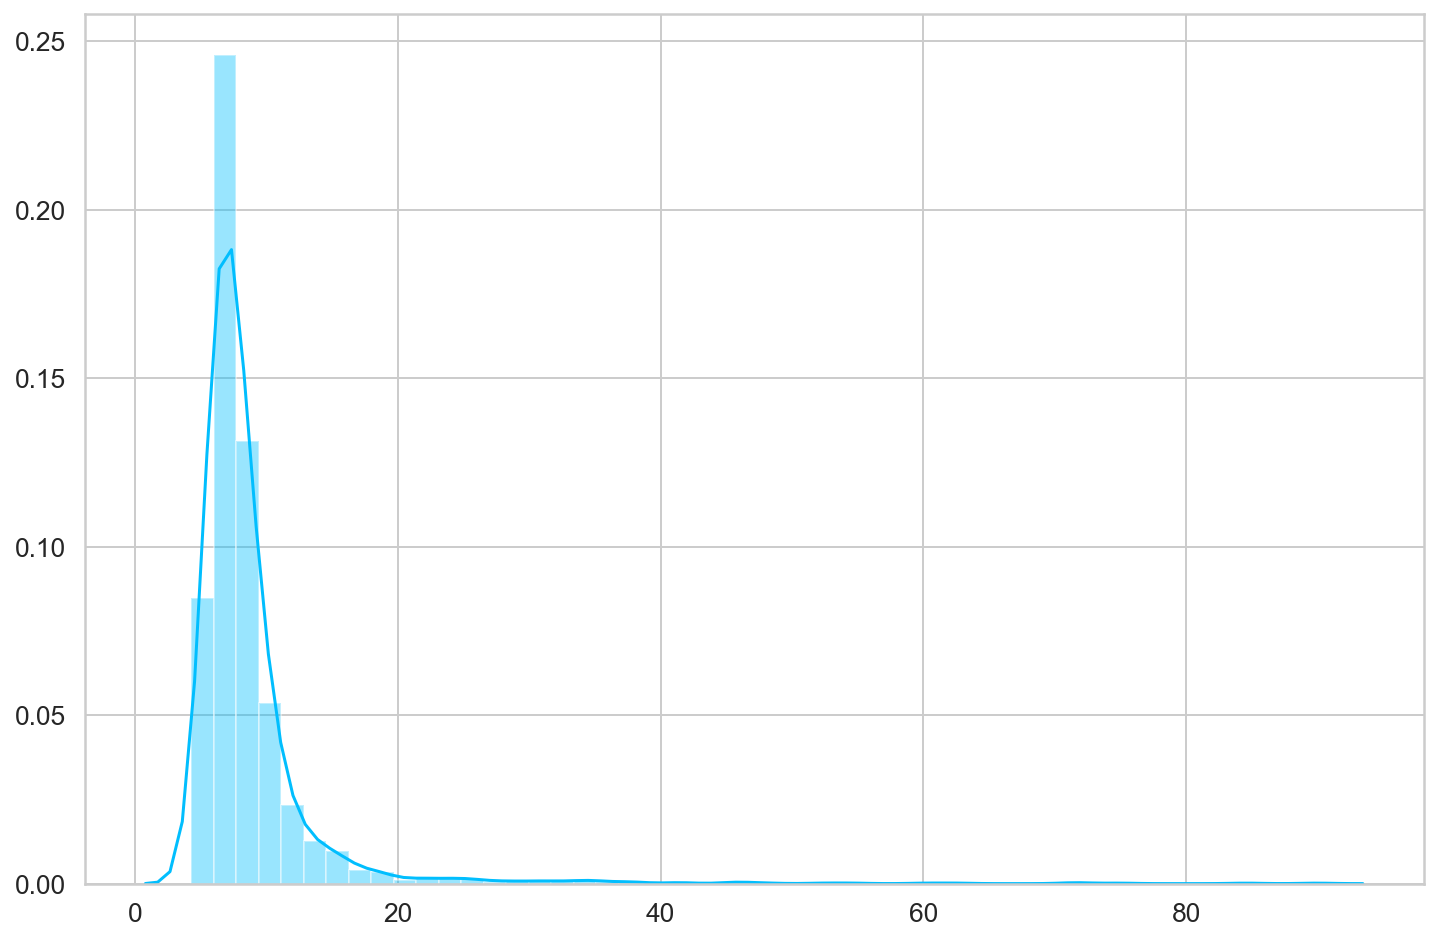

In [39]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True)

We choose the threshold as 26

In [40]:
THRESHOLD = 26

### Evaluation

#### Normal heartbeats

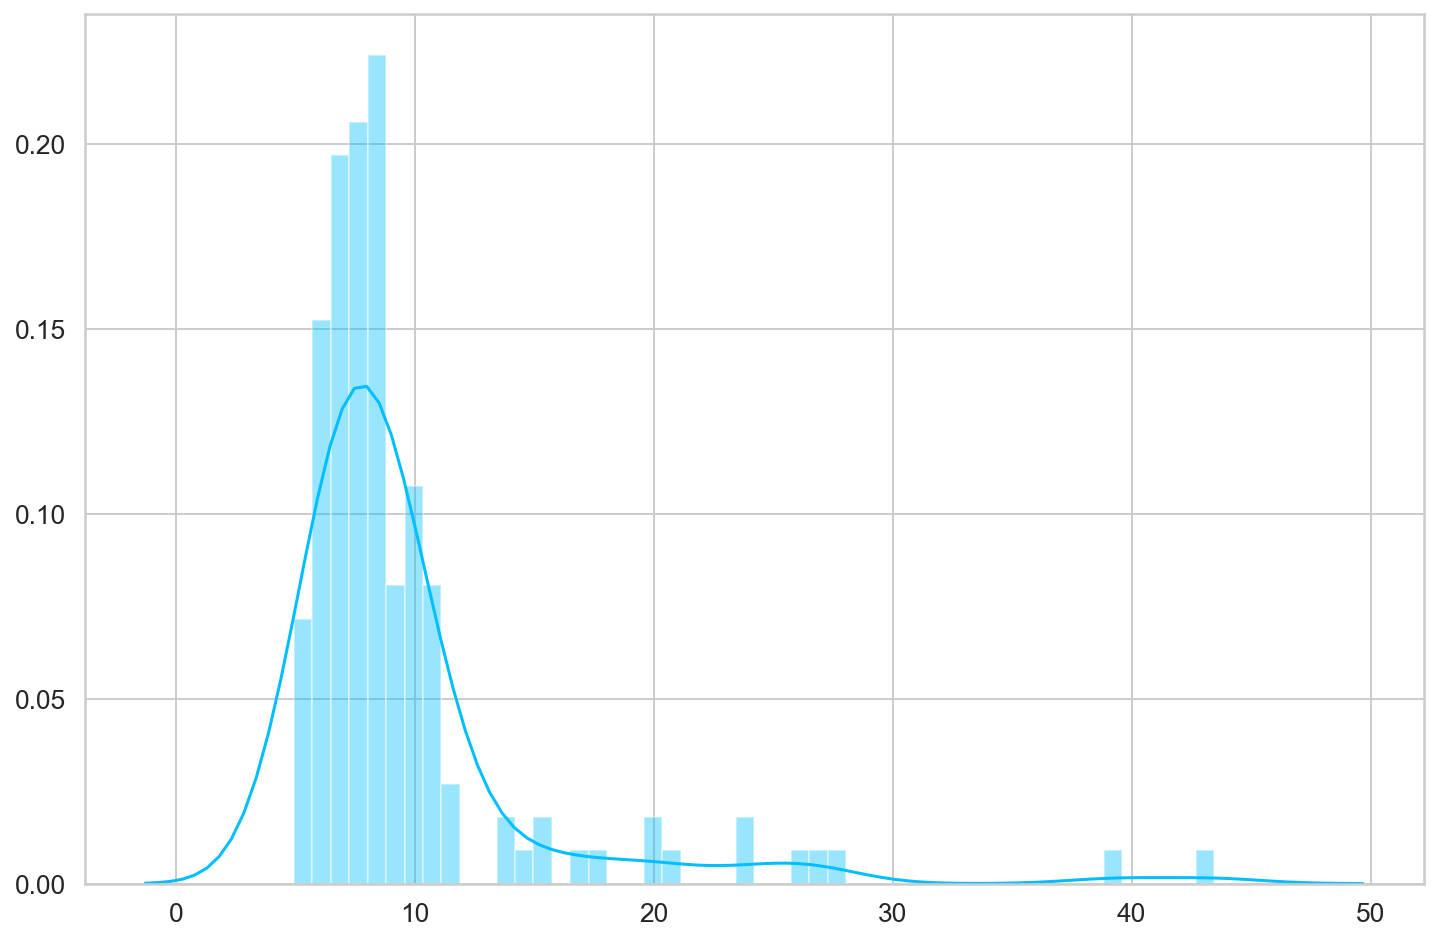

In [41]:
_, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

correct predictions

In [42]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print('Correct normal predictions: {} out of {}'.format(correct, len(test_normal_dataset)))

Correct normal predictions: 140 out of 145


### Anomalies

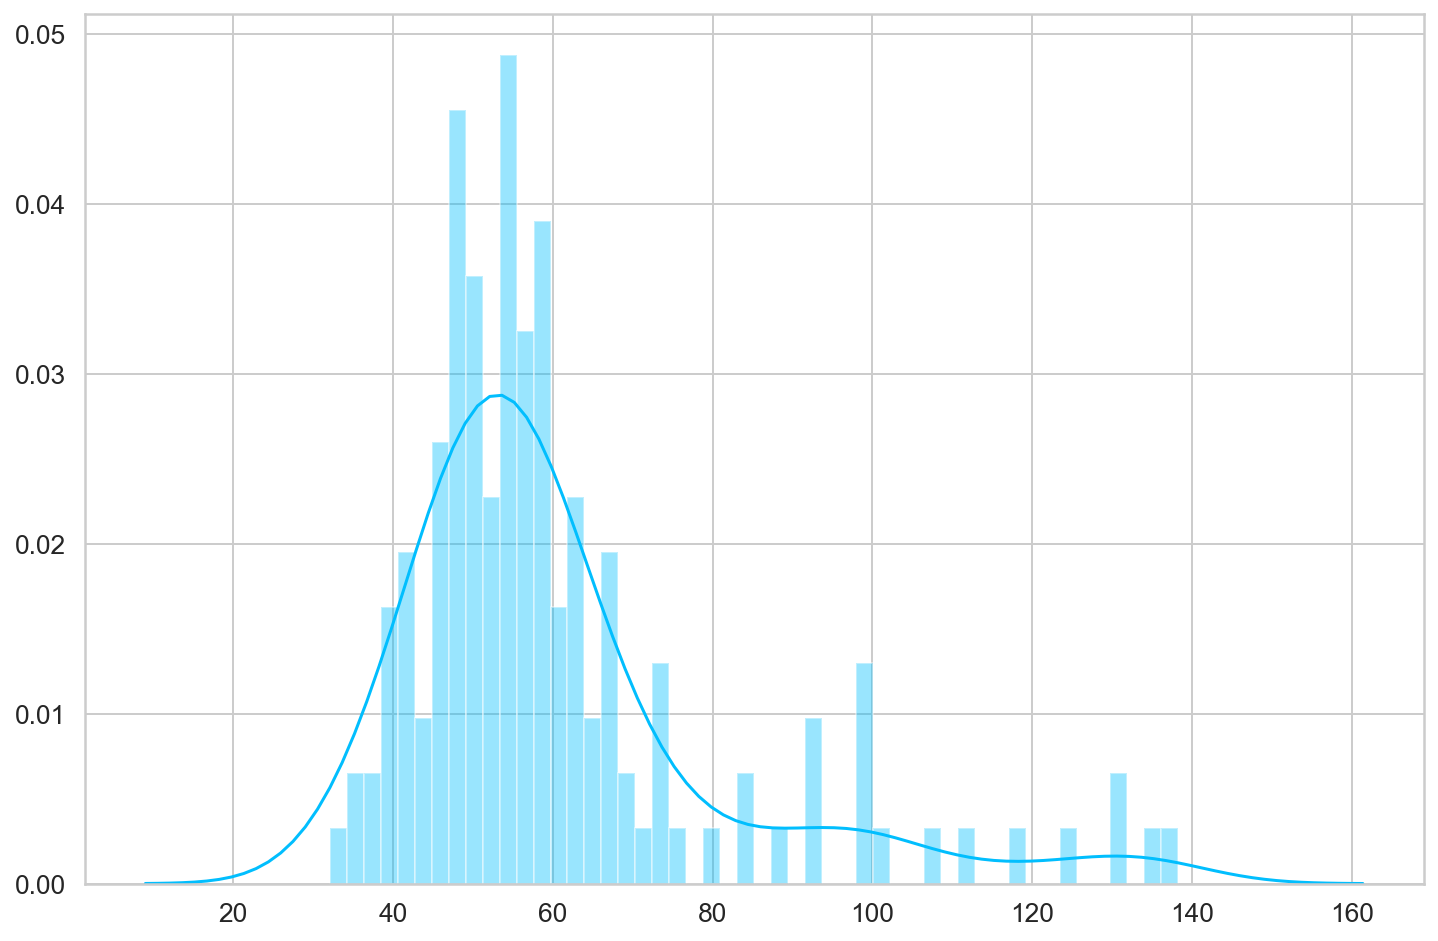

In [43]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [45]:
correct = sum(l > THRESHOLD for l in pred_losses)
print('Correct normal predictions: {} out of {}'.format(correct, len(anomaly_dataset)))

Correct normal predictions: 145 out of 145


#### Looking ata Examples

We overlay the real and reconstructed Time Series values to see how similar they are. Using the normal and anomaly cases:

In [49]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title('{} (loss: {})'.format(title, np.around(pred_losses[0], 2)))
    ax.legend()

Considering the first 6 signals


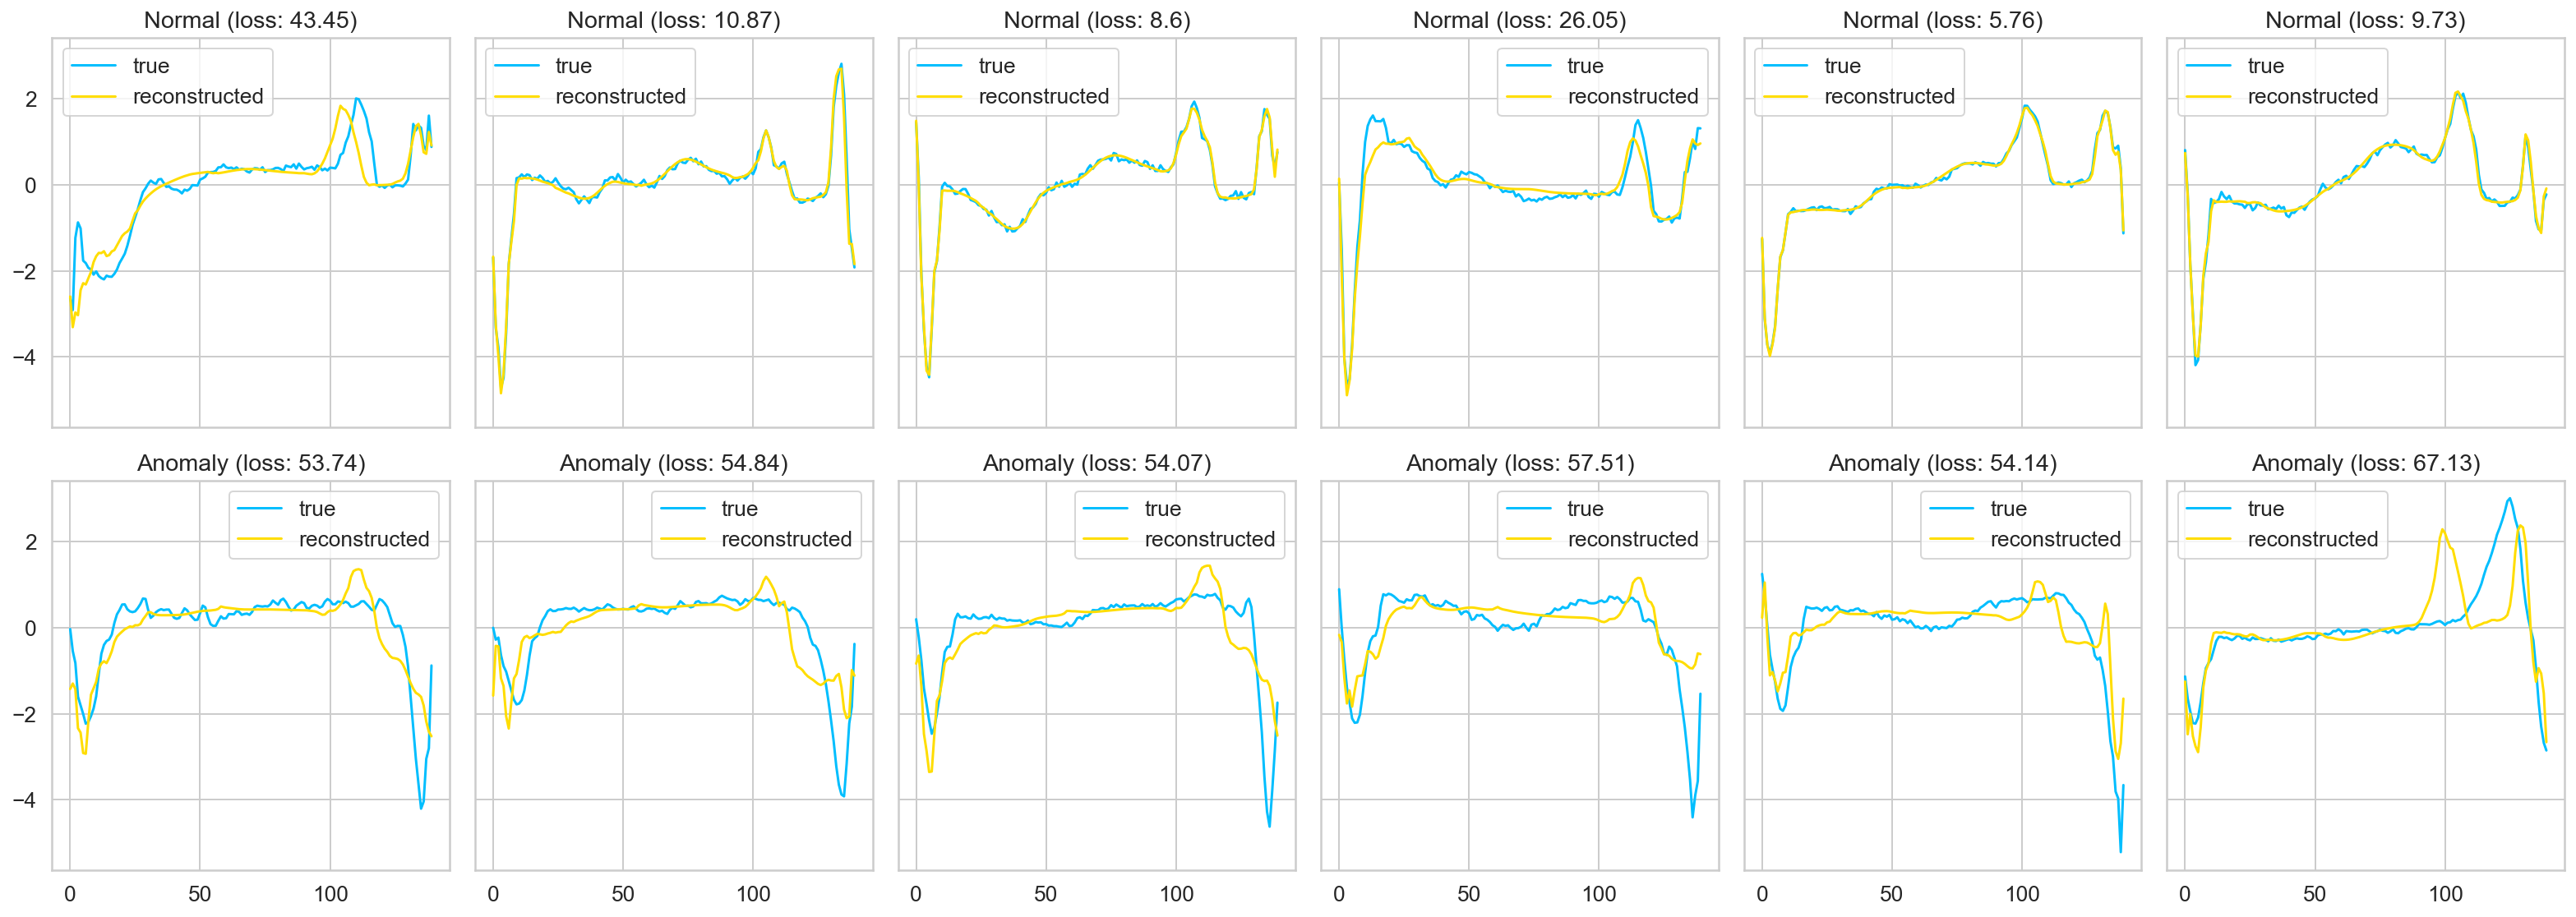

In [51]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22,8)
)

print('Considering the first 6 signals')

for idx, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, idx])
    
for idx, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, idx])
    
fig.tight_layout()